# 📊 BIG DATA ANALYSIS: ORO & ARGENTO
## Analisi dei Metalli Preziosi come Beni Rifugio (2000-2026)

---

## Introduzione

L'oro e l'argento sono da millenni considerati **beni rifugio** - asset che mantengono o aumentano il loro valore durante periodi di incertezza economica e geopolitica. Questo notebook analizza 26 anni di dati per rispondere a domande chiave:

- **Come reagiscono** oro e argento durante le crisi globali?
- **Esiste una relazione predittiva** tra i due metalli?
- **Possiamo quantificare** la correlazione e costruire un modello?

---

## Caratteristiche Big Data del Dataset

| Dimensione | Descrizione | Valore |
|------------|-------------|--------|
| **Volume** | Record giornalieri per asset | ~6.400 (26 anni × ~250 giorni trading) |
| **Varietà** | Tipologie di informazione | Quantitativa (prezzi) + Qualitativa (eventi storici) |
| **Velocity** | Granularità temporale | Giornaliera |

---

## Struttura del Notebook

1. **Setup e Caricamento Dati**
2. **Comprensione della Fonte Dati** (SPOT vs Futures)
3. **Pulizia e Pre-elaborazione**
4. **Feature Engineering**
5. **Visualizzazione con Timeline Eventi**
6. **Analisi Statistica Avanzata**
7. **Modello Predittivo**
8. **Conclusioni**

---

# 1. SETUP E CONFIGURAZIONE

## Perché queste librerie?

Ogni libreria è stata scelta per un motivo specifico:

| Libreria | Ruolo nel Progetto |
|----------|--------------------|
| **pandas** | Gestione di grandi dataset tabulari |
| **numpy** | Operazioni vettoriali ottimizzate (fondamentale per 6.400+ record) |
| **matplotlib** | Visualizzazioni personalizzabili con annotazioni per eventi storici |
| **statsmodels** | Test statistici accademici peer-reviewed OLS |
| **scikit-learn** | Algoritmi ML industry-standard con API consistente |
| **seaborn** | Visualizzazioni statistiche avanzate e stile grafico professionale |


**Pandas** rappresenta il "cuore" dell'analisi dati in Python. La sua struttura `DataFrame` permette di:
- Gestire dati **tabulari** con righe e colonne etichettate
- Eseguire **operazioni vettoriali** senza loop espliciti
- Applicare funzioni di **aggregazione** e **trasformazione** efficienti
- Gestire nativamente **serie temporali** con indici `DatetimeIndex`

L'integrazione con **numpy** garantisce performance ottimali anche su dataset con migliaia di record, sfruttando operazioni a basso livello in C.

In [1]:
# =============================================================================
# IMPORTAZIONE LIBRERIE
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import seaborn as sns
import warnings
#from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

# Analisi statistica
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Configurazione
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("✅ Librerie caricate correttamente")

✅ Librerie caricate correttamente


---

# 2. COMPRENSIONE DELLA FONTE DATI

## Mercato SPOT vs Mercato FUTURES

Prima di analizzare i dati, è fondamentale capire da dove provengono e quali sono le loro caratteristiche.

### Mercato SPOT ("Pronti")

Il prezzo **SPOT** rappresenta il valore del metallo **"qui e ora"** - il prezzo che pagheresti per acquistare un'oncia fisica con consegna immediata.

**Caratteristiche:**
- ✅ Prezzo "puro" del metallo fisico
- ✅ Nessuna distorsione da scadenze contrattuali
- ✅ Serie storica continua (ideale per analisi)
- ❌ **Mercato OTC** (Over-The-Counter): transazioni private tra banche
- ❌ **Dati storici non disponibili** gratuitamente

### Mercato FUTURES

I **FUTURES** sono contratti standardizzati per comprare/vendere a una data futura, scambiati su borse regolamentate (COMEX).

**Caratteristiche:**
- ✅ Dati storici disponibili gratuitamente (Yahoo Finance)
- ✅ Borsa regolamentata = cronologia verificabile
- ⚠️ **Rollover Gaps**: discontinuità quando un contratto scade

### La Nostra Scelta

Avremmo preferito i dati SPOT, ma non sono disponibili gratuitamente. Utilizziamo quindi i **FUTURES** (ticker GC=F e SI=F), correggendo i rollover gaps con tecniche appropriate.

### Variabili Aggiuntive per Regressione Multipla

Per costruire un modello predittivo più robusto, aggiungiamo due variabili macroeconomiche:

| Ticker | Nome | Descrizione |
|--------|------|-------------|
| **^GSPC** | S&P 500 | Indice azionario USA (500 maggiori aziende) - indicatore *risk-on* |
| **^VIX** | VIX Index | *Fear Gauge* - misura la volatilità implicita attesa dal mercato |

**Perché queste variabili?**

- **S&P 500**: Quando il mercato azionario sale (*risk-on*), gli investitori preferiscono azioni ad alto rendimento → l'oro tende a scendere
- **VIX**: Quando la paura aumenta (VIX alto), gli investitori cercano beni rifugio → oro e argento salgono

Queste variabili saranno usate come **feature indipendenti** nella regressione multipla per predire il prezzo dell'argento.

In [2]:
#Libreria: pandas
# =============================================================================
# CARICAMENTO DATI
# =============================================================================
# I dati sono stati scaricati dallo script download_data.py
# Lo script esegue 3 FASI:
#   FASE 1: Tenta download SPOT → fallisce (mercato OTC)
#   FASE 2: Download Futures → successo
#   FASE 3: Merge → non possibile (solo Futures disponibili)

df = pd.read_csv('data/precious_metals_data.csv', 
                 index_col=0, 
                 parse_dates=True)

df.index.name = 'Date'

print("📂 RIEPILOGO DATASET (dati grezzi)")
print("=" * 50)
print(f"Fonte: FUTURES (GC=F, SI=F) - Borsa COMEX")
print(f"Periodo: {df.index.min().strftime('%Y-%m-%d')} → {df.index.max().strftime('%Y-%m-%d')}")
print(f"Record totali: {len(df):,}")
print(f"Anni coperti: {(df.index.max() - df.index.min()).days / 365.25:.1f}")
print(f"\nValori mancanti (prima della pulizia):")
print(df.isna().sum())
print(f"\nPrime righe:")
df.head()

📂 RIEPILOGO DATASET (dati grezzi)
Fonte: FUTURES (GC=F, SI=F) - Borsa COMEX
Periodo: 2000-01-03 → 2026-01-27
Record totali: 6,562
Anni coperti: 26.1

Valori mancanti (prima della pulizia):
Gold_USD      187
Silver_USD    185
SP500           6
VIX             6
dtype: int64

Prime righe:


,Gold_USD,Silver_USD,SP500,VIX
Date,,,,
2000-01-03,NaN,NaN,1455.219971,24.209999
2000-01-04,NaN,NaN,1399.420044,27.010000
2000-01-05,NaN,NaN,1402.109985,26.410000
2000-01-06,NaN,NaN,1403.449951,25.730000
2000-01-07,NaN,NaN,1441.469971,21.719999


---

# 3 Gestione Valori Mancanti nel Dataset

## 3.1 📊 Situazione del Dataset

Il file `precious_metals_data.csv` contiene **solo giorni di trading** (circa 252 giorni/anno invece di 365). Weekend e festività sono già esclusi dalla fonte dati (Yahoo Finance).

Tuttavia, alcuni valori sono **vuoti (NaN)** per due motivi:

| Causa | Descrizione | Esempio |
|-------|-------------|---------|
| **Dati storici non disponibili** | I futures Oro/Argento su Yahoo Finance iniziano da Agosto 2000, mentre SP500/VIX partono da Gennaio 2000 | Prime ~168 righe senza Gold_USD e Silver_USD |
| **Festività specifiche per asset** | Alcuni mercati chiudono in giorni diversi (es. Thanksgiving USA chiude equity ma non commodities) | Righe sparse con 1-2 colonne vuote |

---

## ✅ Codice per Eliminare i NaN

In [3]:
#Libreria: pandas
# =============================================================================
# PULIZIA 1: GESTIONE VALORI MANCANTI
# =============================================================================

righe_prima = len(df)
righe_con_nan = df.isna().any(axis=1).sum()  # Conta le RIGHE con almeno un NaN
print(f"📊 Righe totali PRIMA: {righe_prima:,}")
print(f"📊 Righe con almeno un NaN: {righe_con_nan}")

# Elimina tutte le righe con almeno un NaN
df = df.dropna()

righe_dopo = len(df)
print(f"📊 Righe totali DOPO: {righe_dopo:,}")
print(f"   Record rimossi: {righe_prima - righe_dopo}")
print(f"\n✅ Problema 1 risolto: dataset senza NaN")

📊 Righe totali PRIMA: 6,562
📊 Righe con almeno un NaN: 193
📊 Righe totali DOPO: 6,369
   Record rimossi: 193

✅ Problema 1 risolto: dataset senza NaN


## 3.2 Problema: Rollover Gaps (Specifico dei Futures)

### Cos'è un Rollover Gap?

I contratti Futures hanno una **data di scadenza**. Quando un contratto scade, gli investitori "rollano" le posizioni al contratto successivo. Questo può causare **discontinuità artificiali** nel prezzo.

**Esempio:** Il contratto di marzo scade a $1.800, quello di aprile apre a $1.820 → gap di $20 non legato al mercato reale.

### Come li identifichiamo?

Cerchiamo variazioni giornaliere **anomale** (>5%) che potrebbero essere rollover anziché movimenti di mercato reali.

### Possibili soluzione:

| Tecnica | Come funziona | Pro | Contro |
|---------|---------------|-----|--------|
| **Back-adjusted** | Modifica tutti i prezzi storici | Elimina gap | ❌ Distorce prezzi assoluti |
| **Proportional-adjusted** | Mantiene rapporti percentuali | ✅ Rendimenti intatti | Gap visibili |


#### Soluzione Scelta
In alternativa all’aggiustamento proportional-adjusted, i rollover dei futures sono stati gestiti tramite filtraggio dei rendimenti anomali, evitando modifiche retroattive dei prezzi e preservando la struttura originale della serie temporale.
Dato che l’analisi è condotta sui returns e non sui livelli di prezzo, la perdita di alcune osservazioni non compromette la validità statistica del modello.

In [4]:
#Libreria: pandas
# =============================================================================
# PULIZIA 2: IDENTIFICAZIONE ROLLOVER GAPS
# =============================================================================
# Identifichiamo variazioni giornaliere anomale (>5%) che potrebbero essere
# rollover gaps. Documentiamo il problema per consapevolezza.

def identifica_rollover_gaps(serie, nome, soglia=0.05):
    """
    Identifica potenziali rollover gaps nella serie.
    Un gap è una variazione >soglia in un singolo giorno.
    """
    rendimenti = serie.pct_change()
    gaps = rendimenti.abs() > soglia
    n_gaps = gaps.sum()
    
    print(f"\n📊 {nome}:")
    print(f"   Variazioni giornaliere >{soglia*100}%: {n_gaps}")
    
    if n_gaps > 0:
        gap_dates = serie.index[gaps]
        print(f"   Date più recenti con gap:")
        for date in gap_dates[-3:]:
            idx = serie.index.get_loc(date)
            if idx > 0:
                prev = serie.iloc[idx-1]
                curr = serie.iloc[idx]
                pct = (curr - prev) / prev * 100
                print(f"      {date.strftime('%Y-%m-%d')}: {prev:.2f} → {curr:.2f} ({pct:+.1f}%)")
    
    return n_gaps

print("=" * 60)
print("IDENTIFICAZIONE ROLLOVER GAPS")
print("=" * 60)

gaps_oro = identifica_rollover_gaps(df['Gold_USD'], 'Oro')
gaps_argento = identifica_rollover_gaps(df['Silver_USD'], 'Argento')


print(f"\n💡 NOTA: Non tutti i gap sono rollover - alcuni sono movimenti reali di mercato")
print(f"   La tecnica Proportional-adjusted mantiene i rendimenti intatti")
print(f"   permettendo analisi statistiche corrette nonostante i gap.")

IDENTIFICAZIONE ROLLOVER GAPS

📊 Oro:
   Variazioni giornaliere >5.0%: 19
   Date più recenti con gap:
      2020-03-23: 1484.00 → 1567.00 (+5.6%)
      2020-03-24: 1567.00 → 1660.20 (+5.9%)
      2025-10-21: 4336.40 → 4087.70 (-5.7%)

📊 Argento:
   Variazioni giornaliere >5.0%: 188
   Date più recenti con gap:
      2026-01-23: 95.98 → 100.93 (+5.2%)
      2026-01-26: 100.93 → 115.08 (+14.0%)
      2026-01-27: 115.08 → 105.52 (-8.3%)

💡 NOTA: Non tutti i gap sono rollover - alcuni sono movimenti reali di mercato
   La tecnica Proportional-adjusted mantiene i rendimenti intatti
   permettendo analisi statistiche corrette nonostante i gap.


---


## 4.1 Variabili Dummy per Eventi Macroeconomici

Le **variabili dummy** (binarie 0/1) catturano l'impatto delle politiche monetarie della Federal Reserve sui metalli preziosi.

| Variabile | Periodo | Evento |
|-----------|---------|--------|
| QE1 | Nov 2008 - Mar 2010 | Risposta crisi Lehman Brothers |
| QE2 | Nov 2010 - Giu 2011 | Secondo round di stimolo |
| QE3 | Set 2012 - Ott 2014 | "Open-ended" QE |
| QE_COVID | Mar 2020 - Mar 2022 | Risposta pandemia |

La variabile **QE_ANY** aggrega tutti i periodi, permettendo di testare l'ipotesi che il Quantitative Easing influenzi i rendimenti dell'argento.

In [5]:
#Libreria: pandas
# =============================================================================
# VARIABILI DUMMY PER EVENTI MACROECONOMICI
# =============================================================================

# Creiamo variabili binarie (0/1) per i periodi di Quantitative Easing
# Queste catturano l'effetto delle politiche monetarie sui metalli preziosi

# QE1 - Risposta crisi Lehman Brothers
df['QE1'] = 0
df.loc['2008-11-25':'2010-03-31', 'QE1'] = 1

# QE2 - Secondo round
df['QE2'] = 0
df.loc['2010-11-03':'2011-06-30', 'QE2'] = 1

# QE3 - Open-ended
df['QE3'] = 0
df.loc['2012-09-13':'2014-10-29', 'QE3'] = 1

# QE COVID - Risposta pandemia
df['QE_COVID'] = 0
df.loc['2020-03-15':'2022-03-09', 'QE_COVID'] = 1

# Variabile aggregata: qualsiasi periodo QE attivo
df['QE_ANY'] = (df['QE1'] | df['QE2'] | df['QE3'] | df['QE_COVID']).astype(int)

print("📊 VARIABILI DUMMY CREATE")
print(f"   Giorni con QE attivo: {df['QE_ANY'].sum():,}")
print(f"   Giorni senza QE: {(1 - df['QE_ANY']).sum():,}")
print(f"   % periodo con QE: {df['QE_ANY'].mean()*100:.1f}%")

📊 VARIABILI DUMMY CREATE
   Giorni con QE attivo: 1,540
   Giorni senza QE: 4,829
   % periodo con QE: 24.2%


## 4.2 Trasformazione in Rendimenti Percentuali

Perché usiamo i **rendimenti** invece dei prezzi assoluti?

| Proprietà | Prezzi Assoluti | Rendimenti % |
|-----------|-----------------|--------------|
| Stazionarietà | Non stazionari | Più stazionari |
| Scala | Oro ~$2000, Argento ~$30 | Comparabili (-5% a +5%) |
| Interpretazione | "L'oro costa $2000" | "L'oro è salito del 1.2%" |

La formula: `rendimento = (prezzo_oggi / prezzo_ieri - 1) × 100`

In [6]:
#Libreria: pandas
# =============================================================================
# TRASFORMAZIONE IN RENDIMENTI PERCENTUALI
# =============================================================================

# I rendimenti percentuali sono più stazionari dei prezzi assoluti

# Calcola rendimenti giornalieri (variazione % rispetto al giorno precedente)
df['Gold_returns'] = df['Gold_USD'].pct_change() * 100
df['Silver_returns'] = df['Silver_USD'].pct_change() * 100
df['VIX_returns'] = df['VIX'].pct_change() * 100

# La prima riga sarà NaN (non c'è giorno precedente)
# Manteniamo il dataframe originale per le variabili dummy
df_returns = df.dropna(subset=['Gold_returns', 'Silver_returns', 'VIX_returns'])

print("📊 RENDIMENTI CALCOLATI")
print(f"   Record originali: {len(df):,}")
print(f"   Record dopo dropna: {len(df_returns):,}")
print(f"\n   Statistiche Gold_returns:")
print(f"   Media: {df_returns['Gold_returns'].mean():.4f}%")
print(f"   Std Dev: {df_returns['Gold_returns'].std():.4f}%")
print(f"   Min: {df_returns['Gold_returns'].min():.2f}%")
print(f"   Max: {df_returns['Gold_returns'].max():.2f}%")

📊 RENDIMENTI CALCOLATI
   Record originali: 6,369
   Record dopo dropna: 6,368

   Statistiche Gold_returns:
   Media: 0.0519%
   Std Dev: 1.0975%
   Min: -9.35%
   Max: 9.03%


In [7]:
#Libreria: pandas
# =============================================================================
# GESTIONE ROLLOVER GAPS
# =============================================================================
# Solo ORO e ARGENTO hanno rollover (sono futures).
# Il VIX è un INDICE, non ha rollover - le sue spike sono REALI.

SOGLIA_ROLLOVER = 5.0  # %

# Identifica rollover SOLO per i futures (non VIX!)
rollover_gold = df_returns['Gold_returns'].abs() > SOGLIA_ROLLOVER
rollover_silver = df_returns['Silver_returns'].abs() > SOGLIA_ROLLOVER

# Maschera: rimuovi se Gold O Silver hanno rollover
rollover_mask = rollover_gold | rollover_silver

# Crea DataFrame pulito
df_returns_clean = df_returns[~rollover_mask].copy()

print("📊 ROLLOVER GAPS RIMOSSI (solo Futures)")
print(f"   Rollover Gold: {rollover_gold.sum()}")
print(f"   Rollover Silver: {rollover_silver.sum()}")
print(f"   Record rimossi: {rollover_mask.sum()}")
print(f"   Record finali: {len(df_returns_clean):,}")

📊 ROLLOVER GAPS RIMOSSI (solo Futures)
   Rollover Gold: 19
   Rollover Silver: 188
   Record rimossi: 190
   Record finali: 6,178


---

# 5. VISUALIZZAZIONE CON TIMELINE EVENTI

## I Metalli Preziosi come "Termometri della Paura"

Oro e argento reagiscono alle crisi globali. Ogni **spike** nei prezzi corrisponde a un evento che ha generato incertezza:

- **Crisi finanziarie** → Fuga verso asset "sicuri"
- **Tensioni geopolitiche** → Domanda di beni rifugio
- **Inflazione** → Protezione del potere d'acquisto

Visualizzare gli eventi storici sui grafici ci permette di **validare** questa correlazione.

In [8]:
# =============================================================================
# DEFINIZIONE EVENTI STORICI - FOCUS FED/QE SHOCKS
# =============================================================================

EVENTI_STORICI = [
    # Lehman Brothers - Risposta crisi 2008
    {'tipo': 'periodo', 'inizio': '2008-11-25', 'fine': '2010-03-31',
     'nome': 'Lehman Brothers Crisi Finanziaria', 'colore': 'blue', 'alpha': 0.2},
    
    # QE2
    {'tipo': 'periodo', 'inizio': '2010-11-03', 'fine': '2011-06-30',
     'nome': 'QE2 (FED)', 'colore': 'purple', 'alpha': 0.2},
    
    # QE3 (Infinity)
    {'tipo': 'periodo', 'inizio': '2012-09-13', 'fine': '2014-10-29',
     'nome': 'QE3 (FED)', 'colore': 'teal', 'alpha': 0.2},
    
    # COVID QE
    {'tipo': 'periodo', 'inizio': '2020-03-15', 'fine': '2022-03-09',
     'nome': 'COVID QE (FED)', 'colore': 'green', 'alpha': 0.2},
    
    # Inflazione post-COVID
    {'tipo': 'periodo', 'inizio': '2021-06-01', 'fine': '2022-12-31',
     'nome': 'Inflazione Globale', 'colore': 'red', 'alpha': 0.15},
    
    # Guerra Ucraina
    {'tipo': 'punto', 'data': '2022-02-24',
     'nome': 'Invasione Ucraina', 'colore': 'darkred'},
]

print(f"✅ Definiti {len(EVENTI_STORICI)} eventi storici (focus FED/QE)")

✅ Definiti 6 eventi storici (focus FED/QE)


## 5.1 Grafico Principale: L'Effetto Safe Haven

Questo grafico rappresenta il **cuore della tesi**: dimostra visivamente come oro e argento reagiscano agli shock globali.

### Come leggere il grafico

| Elemento | Significato |
|----------|-------------|
| **Linea oro/argento** | Andamento del prezzo nel tempo |
| **Zone colorate** | Periodi di politica monetaria espansiva (QE) |
| **Linee verticali tratteggiate** | Eventi puntuali (shock) |

### Legenda Eventi FED/QE

| Colore | Evento | Periodo |
|--------|--------|--------|
| 🔵 Blu | Lehman Brothers Crisi Finanziaria | Nov 2008 - Mar 2010 |
| 🟣 Viola | QE2 (FED) | Nov 2010 - Giu 2011 |
| 🩵 Teal | QE3 (FED) | Set 2012 - Ott 2014 |
| 🟢 Verde | COVID QE | Mar 2020 - Mar 2022 |
| 🔴 Rosso | Inflazione Globale | Giu 2021 - Dic 2022 |
| ⬛ Nero | Invasione Ucraina | Feb 2022 |

**Insight atteso:** Durante i periodi di QE, i prezzi dei metalli preziosi SALGONO → l'espansione monetaria svaluta il dollaro.

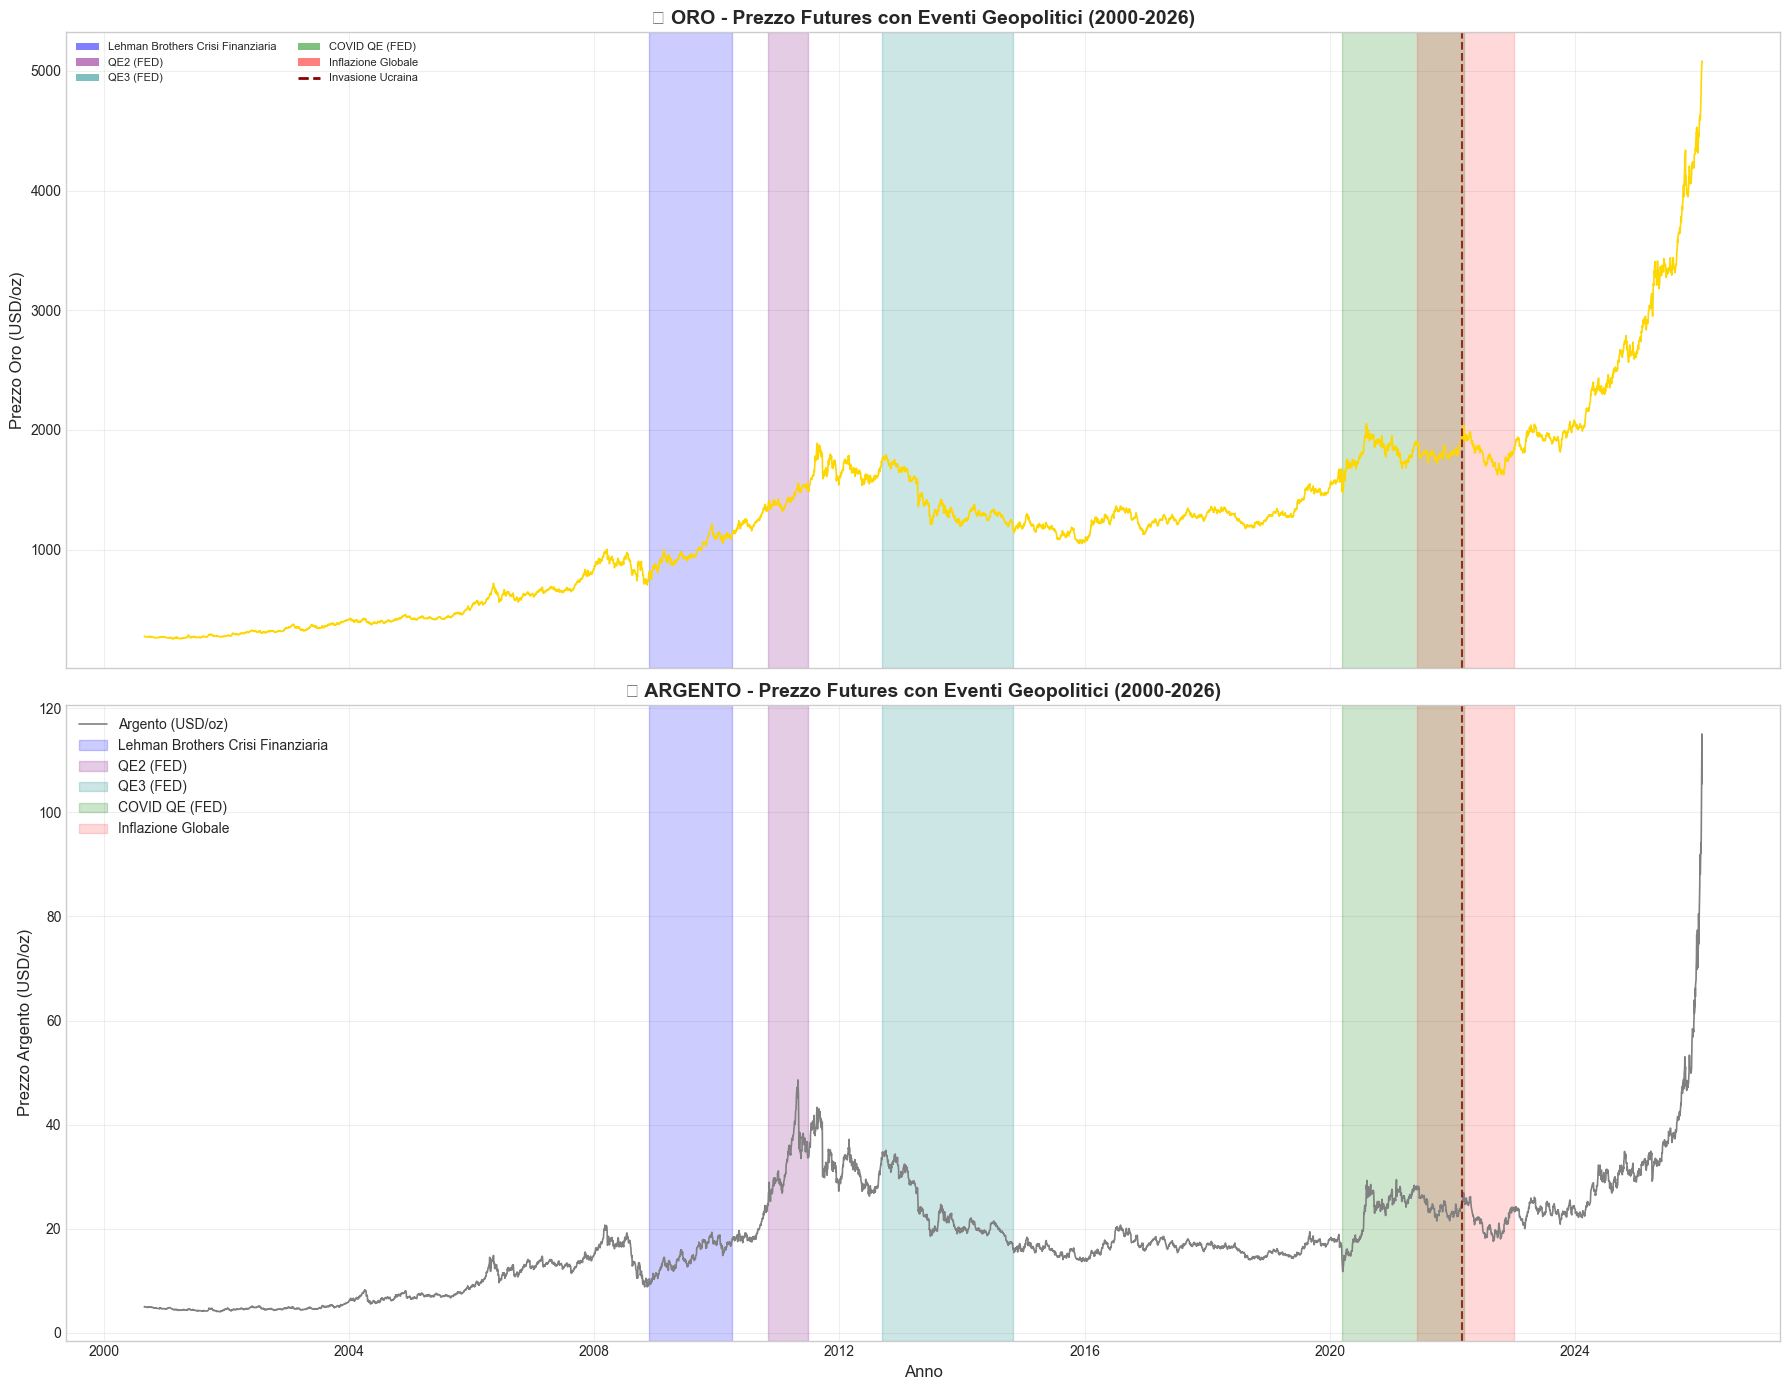


💾 Grafico salvato: data/safe_haven_eventi.png
💡 INSIGHT: Nota come i prezzi SALGONO durante le zone colorate (crisi)


In [9]:
#Librerie: pandas, matplotlib
# =============================================================================
# GRAFICO PREZZI CON EVENTI E LEGENDA
# =============================================================================

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 14), sharex=True)

# Oro
ax1.plot(df.index, df['Gold_USD'], color='gold', linewidth=1.2, label='Oro (USD/oz)')
ax1.set_ylabel('Prezzo Oro (USD/oz)', fontsize=12)
ax1.set_title('🥇 ORO - Prezzo Futures con Eventi Geopolitici (2000-2026)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Argento
ax2.plot(df.index, df['Silver_USD'], color='gray', linewidth=1.2, label='Argento (USD/oz)')
ax2.set_ylabel('Prezzo Argento (USD/oz)', fontsize=12)
ax2.set_xlabel('Anno', fontsize=12)
ax2.set_title('🥈 ARGENTO - Prezzo Futures con Eventi Geopolitici (2000-2026)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Annotazione eventi su entrambi i grafici
for ax in [ax1, ax2]:
    for evento in EVENTI_STORICI:
        if evento['tipo'] == 'periodo':
            ax.axvspan(pd.Timestamp(evento['inizio']), 
                       pd.Timestamp(evento['fine']),
                       alpha=evento['alpha'], 
                       color=evento['colore'],
                       label=evento['nome'].replace('\n', ' '))
        else:
            data = pd.Timestamp(evento['data'])
            if data >= df.index.min() and data <= df.index.max():
                ax.axvline(data, color=evento['colore'], 
                          linestyle='--', alpha=0.8, linewidth=1.5)

# Legenda eventi (solo su ax1)
legend_patches = []
for evento in EVENTI_STORICI:
    if evento['tipo'] == 'periodo':
        legend_patches.append(Patch(facecolor=evento['colore'], alpha=0.5, 
                                    label=evento['nome'].replace('\n', ' ')))
    else:
        legend_patches.append(plt.Line2D([0], [0], color=evento['colore'], 
                                         linestyle='--', linewidth=2,
                                         label=evento['nome']))

ax1.legend(handles=legend_patches, loc='upper left', fontsize=8, ncol=2)
ax2.legend(loc='upper left')

plt.tight_layout()
plt.savefig('data/safe_haven_eventi.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💾 Grafico salvato: data/safe_haven_eventi.png")
print("💡 INSIGHT: Nota come i prezzi SALGONO durante le zone colorate (crisi)")

### Cosa si evince dal grafico

Il grafico conferma l'**effetto safe-haven** dei metalli preziosi durante i periodi di turbolenza economica:

- **Durante i QE (zone colorate)**, i prezzi di oro e argento mostrano una tendenza **ascendente**. Questo è coerente con la teoria economica: l'iniezione di liquidità nel sistema finanziario svaluta il dollaro, rendendo i metalli preziosi più attraenti come riserva di valore.
- **L'oro tende a reagire prima** dell'argento, confermando il suo ruolo primario come bene rifugio.
- **L'invasione dell'Ucraina** (linea tratteggiata nera) ha causato un picco immediato nei prezzi, dimostrando la sensibilità dei metalli agli shock geopolitici.
- **Il periodo 2020-2022** (COVID QE + Inflazione) mostra i rialzi più significativi, con l'oro che supera i 2000 $/oz per la prima volta nella storia.

Questa evidenza grafica supporta l'ipotesi centrale del progetto: **oro e argento fungono da copertura contro l'incertezza macroeconomica**.

## Gold-Silver Ratio: Indicatore di Sentiment

### Cos'è il Gold-Silver Ratio (GSR)?
Il GSR è il rapporto tra il prezzo dell'oro e il prezzo dell'argento:

$$\text{GSR} = \frac{\text{Prezzo Oro (USD/oz)}}{\text{Prezzo Argento (USD/oz)}}$$

Indica **quante once d'argento servono per comprare un'oncia d'oro**. È usato come indicatore del sentiment di mercato.

### Come leggere il grafico

| Zona | GSR | Colore | Interpretazione |
|------|-----|--------|----------------|
| **Paura** | > 80 | 🔴 Rosso | Crisi/incertezza. Gli investitori preferiscono l'oro (rifugio primario) all'argento |
| **Neutro** | 40-80 | Bianco | Mercato in equilibrio |
| **Euforia** | < 40 | 🟢 Verde | Ottimismo. L'argento (più volatile) performa meglio dell'oro |

La **linea rossa tratteggiata** indica la media storica (~69).

### Pattern storici osservabili
- **2008 (Lehman)**: GSR sale verso 80 → paura finanziaria
- **2011**: GSR scende a ~32 → picco dell'argento, euforia sui metalli
- **2020 (COVID)**: GSR schizza a **126** → panico estremo, massimo storico

### ⚠️ Nota Importante: Periodo 2024-2026

Nel periodo 2024-2026 si osserva un **apparente paradosso**:
- I prezzi di oro e argento **salgono entrambi** (come durante le crisi)
- Ma il GSR **scende** verso la zona verde (tipica dell'euforia)

**Spiegazione**: L'argento sta crescendo **più velocemente** dell'oro. Questo non indica necessariamente "euforia" ma piuttosto:
1. **Paura dell'inflazione**: entrambi i metalli salgono come hedge, ma l'argento beneficia anche della domanda industriale (pannelli solari, EV, elettronica)
2. **Catch-up dell'argento**: dopo anni di sottovalutazione (GSR a 90+), l'argento sta recuperando terreno
3. **Transizione energetica**: la domanda industriale di argento per tecnologie green supera quella dell'oro

Le etichette "Paura" e "Euforia" sono basate su pattern storici e potrebbero **non applicarsi** a regimi di mercato nuovi come l'inflazione strutturale post-COVID.


In [10]:
#Libreria: pandas
# =============================================================================
# CREAZIONE FEATURES
# =============================================================================

# Gold-Silver Ratio
df['GS_Ratio'] = df['Gold_USD'] / df['Silver_USD']

print("📊 FEATURES E VARIABILI")
print("=" * 50)

print(f"\n📋 Colonne disponibili: {list(df.columns)}")

print(f"\n🥇 Gold-Silver Ratio:")
print(f"   Media storica: {df['GS_Ratio'].mean():.1f}")
print(f"   Minimo: {df['GS_Ratio'].min():.1f} ({df['GS_Ratio'].idxmin().strftime('%Y-%m-%d')})")
print(f"   Massimo: {df['GS_Ratio'].max():.1f} ({df['GS_Ratio'].idxmax().strftime('%Y-%m-%d')})")

print(f"\n📈 Variabili per Regressione Multipla:")
print(f"   S&P 500 range: ${df['SP500'].min():,.0f} - ${df['SP500'].max():,.0f}")
print(f"   VIX range: {df['VIX'].min():.1f} - {df['VIX'].max():.1f}")

df.head()

📊 FEATURES E VARIABILI

📋 Colonne disponibili: ['Gold_USD', 'Silver_USD', 'SP500', 'VIX', 'QE1', 'QE2', 'QE3', 'QE_COVID', 'QE_ANY', 'Gold_returns', 'Silver_returns', 'VIX_returns', 'GS_Ratio']

🥇 Gold-Silver Ratio:
   Media storica: 69.2
   Minimo: 32.0 (2011-04-25)
   Massimo: 125.9 (2020-03-18)

📈 Variabili per Regressione Multipla:
   S&P 500 range: $677 - $6,979
   VIX range: 9.1 - 82.7


,Gold_USD,Silver_USD,SP500,VIX,QE1,QE2,QE3,QE_COVID,QE_ANY,Gold_returns,Silver_returns,VIX_returns,GS_Ratio
Date,,,,,,,,,,,,,
2000-08-30,273.899994,4.930,1502.589966,17.690001,0,0,0,0,0,NaN,NaN,NaN,55.557810
2000-08-31,278.299988,5.003,1517.680054,16.840000,0,0,0,0,0,1.606424,1.480729,-4.804977,55.626624
2000-09-01,277.000000,5.004,1520.770020,17.530001,0,0,0,0,0,-0.467117,0.019996,4.097390,55.355713
2000-09-05,275.799988,4.998,1507.079956,19.820000,0,0,0,0,0,-0.433217,-0.119905,13.063314,55.182069
2000-09-06,274.200012,4.983,1492.250000,20.790001,0,0,0,0,0,-0.580122,-0.300127,4.894053,55.027097


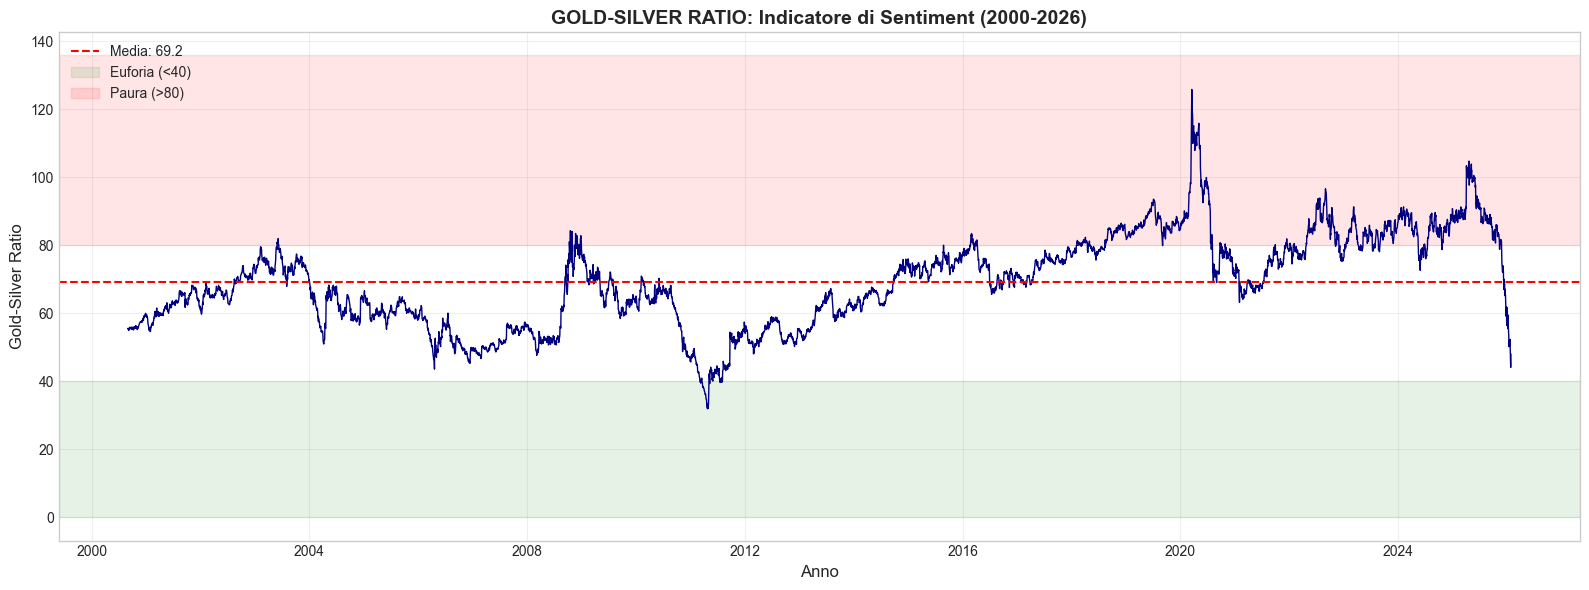


💡 INSIGHT: Il picco del GSR durante il COVID-19 mostra paura estrema


In [11]:
#Librerie: pandas, matplotlib
# =============================================================================
# GOLD-SILVER RATIO
# =============================================================================

fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(df.index, df['GS_Ratio'], color='navy', linewidth=1)
ax.axhline(y=df['GS_Ratio'].mean(), color='red', linestyle='--', 
           label=f'Media: {df["GS_Ratio"].mean():.1f}')

# Zone
ax.axhspan(0, 40, alpha=0.1, color='green', label='Euforia (<40)')
ax.axhspan(80, df['GS_Ratio'].max() + 10, alpha=0.1, color='red', label='Paura (>80)')

ax.set_xlabel('Anno', fontsize=12)
ax.set_ylabel('Gold-Silver Ratio', fontsize=12)
ax.set_title('GOLD-SILVER RATIO: Indicatore di Sentiment (2000-2026)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data/gold_silver_ratio.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💡 INSIGHT: Il picco del GSR durante il COVID-19 mostra paura estrema")

## 6.1 Rolling Correlation (Correlazione Mobile)

### Cosa misura?
La correlazione tra oro e argento su una **finestra mobile di 252 giorni** (1 anno di trading).

### Perché 252 giorni?
- ~250 giorni di trading effettivi per anno
- Cattura cicli annuali eliminando rumore di breve termine

### Insight chiave: "Flight to Safety"
Durante le crisi, la correlazione **schizza verso 1.0** perché tutti vogliono beni rifugio. In tempi normali è più bassa perché l'argento ha anche uso industriale.

La **correlazione** misura la forza della relazione lineare tra due variabili.
- **+1**: Correlazione positiva perfetta (quando una sale, l'altra sale)
- **0**: Nessuna correlazione lineare
- **-1**: Correlazione negativa perfetta (quando una sale, l'altra scende)

La finestra mobile ci permette di osservare come questa relazione **cambia nel tempo**, rivelando pattern invisibili con una semplice correlazione statica.

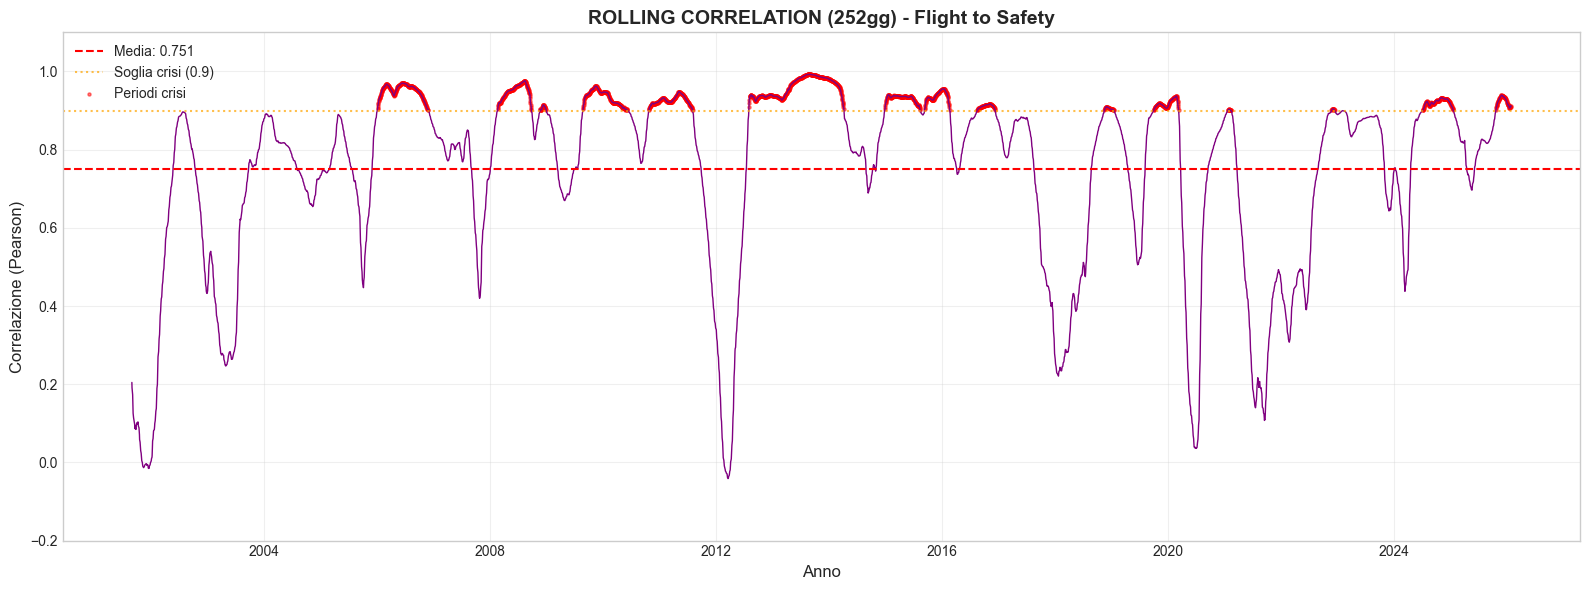


📈 STATISTICHE
   Correlazione media: 0.751
   Giorni con corr > 0.9: 1950

📊 ROLLING CORRELATION AGGIUNTA COME FEATURE
   Record dopo dropna: 5,928


In [12]:
#Librerie: pandas, matplotlib
# =============================================================================
# ROLLING CORRELATION
# =============================================================================

WINDOW = 252  # 1 anno trading

rolling_corr = df['Gold_USD'].rolling(window=WINDOW).corr(df['Silver_USD'])

# --- GRAFICO ---
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(rolling_corr.index, rolling_corr, color='purple', linewidth=1)
ax.axhline(y=rolling_corr.mean(), color='red', linestyle='--', 
           label=f'Media: {rolling_corr.mean():.3f}')
ax.axhline(y=0.9, color='orange', linestyle=':', alpha=0.7,
           label='Soglia crisi (0.9)')

crisi = rolling_corr[rolling_corr > 0.9]
ax.scatter(crisi.index, crisi, color='red', s=5, alpha=0.5, label='Periodi crisi')

ax.set_xlabel('Anno', fontsize=12)
ax.set_ylabel('Correlazione (Pearson)', fontsize=12)
ax.set_title(f'ROLLING CORRELATION ({WINDOW}gg) - Flight to Safety', 
             fontsize=14, fontweight='bold')
ax.set_ylim(-0.2, 1.1)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data/rolling_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📈 STATISTICHE")
print(f"   Correlazione media: {rolling_corr.mean():.3f}")
print(f"   Giorni con corr > 0.9: {(rolling_corr > 0.9).sum()}")

# =============================================================================
# AGGIUNTA COME FEATURE PER IL MODELLO (Step 7)
# =============================================================================
df['rolling_corr'] = rolling_corr
df_returns_clean['rolling_corr_lag'] = df.loc[df_returns_clean.index, 'rolling_corr'].shift(1)
df_returns_clean = df_returns_clean.dropna(subset=['rolling_corr_lag'])

print(f"\n📊 ROLLING CORRELATION AGGIUNTA COME FEATURE")
print(f"   Record dopo dropna: {len(df_returns_clean):,}")

## 6.2 Matrice di Correlazione Completa

Una **heatmap** delle correlazioni permette di visualizzare tutte le relazioni tra variabili contemporaneamente.

### Interpretazione dei colori

- **Rosso intenso (+1)**: Correlazione positiva perfetta
- **Bianco (0)**: Nessuna correlazione lineare
- **Blu intenso (-1)**: Correlazione negativa perfetta

### Relazioni attese

| Coppia | Correlazione attesa | Motivazione |
|--------|---------------------|-------------|
| Gold-Silver | Alta positiva | Entrambi metalli preziosi |
| Gold-VIX | Positiva | Entrambi "rifugio" in crisi |
| SP500-VIX | Negativa | Risk-on vs Risk-off |
| Gold-SP500 | ? | Dipende dal regime di mercato |

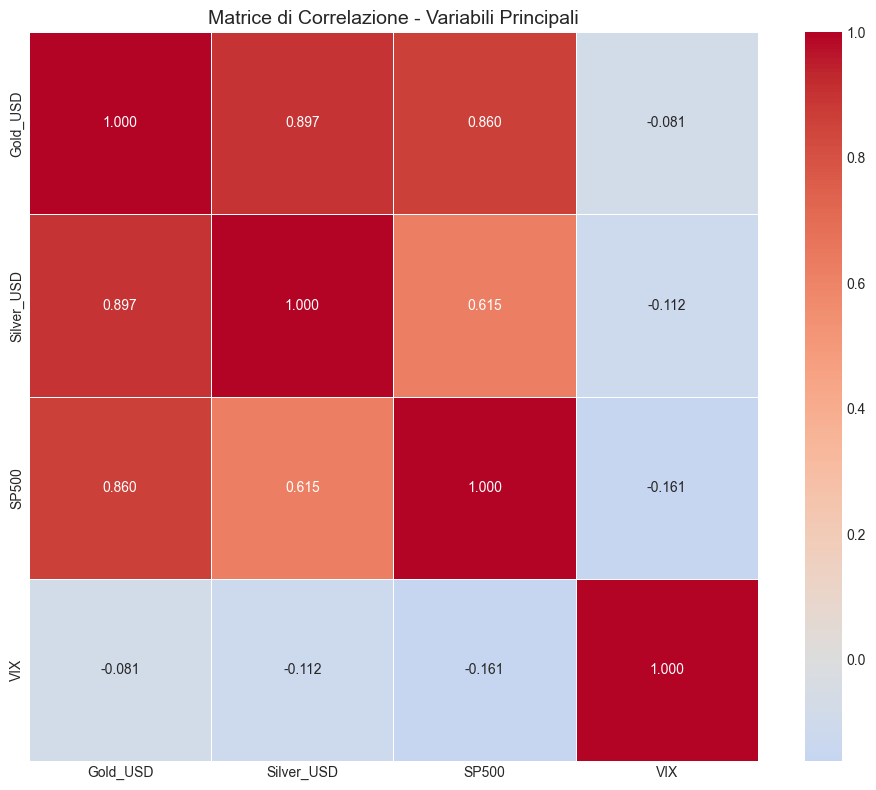


📊 INTERPRETAZIONE CORRELAZIONI
• Gold-Silver: correlazione positiva alta → si muovono insieme
• Gold-VIX: correlazione positiva → entrambi rifugio in crisi
• SP500-VIX: correlazione negativa → risk-on vs risk-off

⚠️ ATTENZIONE: Gold-SP500 correlazione alta può causare multicollinearità!


In [13]:
#Librerie: pandas, matplotlib, seaborn
# =============================================================================
# HEATMAP DELLE CORRELAZIONI
# =============================================================================

import seaborn as sns

# Calcola matrice di correlazione
correlation_matrix = df[['Gold_USD', 'Silver_USD', 'SP500', 'VIX']].corr()

# Crea heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.3f',
            square=True,
            linewidths=0.5)
plt.title('Matrice di Correlazione - Variabili Principali')
plt.tight_layout()
plt.show()

# Interpretazione
print("\n📊 INTERPRETAZIONE CORRELAZIONI")
print("=" * 50)
print("• Gold-Silver: correlazione positiva alta → si muovono insieme")
print("• Gold-VIX: correlazione positiva → entrambi rifugio in crisi")
print("• SP500-VIX: correlazione negativa → risk-on vs risk-off")
print("\n⚠️ ATTENZIONE: Gold-SP500 correlazione alta può causare multicollinearità!")

📊 **Correlazioni osservate:**

| Coppia | Correlazione | Interpretazione |
|--------|--------------|-----------------|
| Gold-Silver | **0.9** | Altissima → si muovono quasi insieme |
| Gold-VIX | **-0.08** | Debole positiva → entrambi rifugio |
| SP500-VIX | **-0.161** | Negativa → quando azioni salgono, paura scende |
| Gold-SP500 | **0.85** | ⚠️ Alta → potenziale multicollinearità! |

⚠️ **ATTENZIONE - Multicollinearità rilevata:**

La correlazione Gold-SP500 di 0.85 è **problematicamente alta** per un modello di regressione:
- Entrambe le variabili catturano informazione simile
- I coefficienti di regressione diventeranno instabili
- **Azione necessaria**: analizzare VIF e potenzialmente rimuovere SP500
```

## 6.3 Analisi Multicollinearità (VIF)

### Cos'è il VIF?
Il **Variance Inflation Factor** misura quanto la varianza di un coefficiente di regressione è "gonfiata" a causa della multicollinearità.

### Interpretazione

| VIF | Interpretazione |
|-----|----------------|
| **1** | Nessuna correlazione |
| **1-5** | Correlazione moderata |
| **5-10** | Alta correlazione |
| **>10** | Multicollinearità grave |

### Perché è importante?
Se le variabili indipendenti (Oro, S&P 500, VIX) sono troppo correlate tra loro, i coefficienti della regressione diventano instabili.

In [14]:
#Librerie: pandas, statsmodels
# =============================================================================
# VIF ANALYSIS - MULTICOLLINEARITÀ
# =============================================================================

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Prepara DataFrame per VIF (variabili indipendenti)
# Rimuoviamo SP500 perché VIF > 10 indica multicollinearità grave con Gold_USD
X_vif = df[['Gold_USD', 'VIX']].dropna()

# Calcola VIF per ogni variabile
vif_data = []
for i, col in enumerate(X_vif.columns):
    vif = variance_inflation_factor(X_vif.values, i)
    vif_data.append({'Variabile': col, 'VIF': vif})

vif_df = pd.DataFrame(vif_data)

print("📊 VARIANCE INFLATION FACTOR (VIF)")
print("=" * 40)
print(vif_df.to_string(index=False))
print()

# Interpretazione automatica
max_vif = vif_df['VIF'].max()
if max_vif > 10:
    print("⚠️ ATTENZIONE: VIF > 10 indica multicollinearità grave!")
elif max_vif > 5:
    print("⚠️ NOTA: VIF > 5 indica alta correlazione tra variabili")
else:
    print("✅ VIF < 5: Multicollinearità accettabile")

📊 VARIANCE INFLATION FACTOR (VIF)
Variabile      VIF
 Gold_USD 2.498049
      VIX 2.498049

✅ VIF < 5: Multicollinearità accettabile


---

# 7. MODELLO PREDITTIVO

## Obiettivo

In questa sezione costruiamo un modello di **regressione multipla** per stimare il **rendimento giornaliero dell'argento** a partire da variabili di mercato. L'utilizzo dei rendimenti percentuali (anziché prezzi assoluti) garantisce serie più stazionarie, migliorando la validità delle assunzioni del modello lineare.

### Variabili del Modello

| Variabile | Tipo | Descrizione |
|-----------|------|-------------|
| **Silver_returns** | Target (y) | Rendimento % giornaliero dell'argento |
| **Gold_returns** | Feature | Rendimento % giornaliero dell'oro |
| **VIX_returns** | Feature | Variazione % del 'fear gauge' |
| **QE_ANY** | Feature (dummy) | 1 se periodo QE attivo, 0 altrimenti |
| **Rolling_corr_lag**| Feature | Finestra di 252 giorni (esclusi festivi sabato e domenica)

> **⚠️ NOTA**: SP500 è stato rimosso a causa della multicollinearità con Gold (VIF > 10)


## Perché Regressione Multipla?

| Caratteristica | Vantaggio |
|----------------|----------|
| **Interpretabilità** | Coefficienti hanno significato economico diretto |
| **Multi-fattoriale** | Cattura relazioni tra più variabili macroeconomiche |
| **Baseline robusta** | Prima di modelli complessi, stabiliamo una baseline |

## Split dei Dati: 55/25/20

| Set | % | Uso |
|-----|---|-----|
| **Training** | 55% | Addestramento modello |
| **Validation** | 25% | Tuning e selezione modello |
| **Test** | 20% | Valutazione finale |

## Metriche di Valutazione

| Metrica | Cosa Misura | Valore Ideale |
|---------|-------------|---------------|
| **R²** | % varianza spiegata | Vicino a 1 |
| **MAE** | Errore medio assoluto | Basso |
| **RMSE** | Errore quadratico (penalizza outlier) | Basso |


### Bias-Variance Trade-off

Ogni modello di ML affronta un trade-off fondamentale:
- **Bias alto** (underfitting): modello troppo semplice, errore su training E test
- **Varianza alta** (overfitting): modello troppo complesso, performa bene su training ma male su test

Il set di **validazione** serve proprio a rilevare l'overfitting *prima* di usare il test set, che rimane "intoccato" per la valutazione finale.

In [15]:
#Libreria: pandas
# =============================================================================
# PREPARAZIONE DATI - SPLIT 55/25/20
# =============================================================================

# Variabili indipendenti: Oro, SP500, VIX, rolling_cor_lag
# NOTA: SP500 rimosso per ridurre multicollinearità
# Aggiungiamo la variabile dummy QE_ANY come feature e rimuovo SP500
# Usare i rendimenti come features
#X = df_returns_clean[['Gold_returns', 'VIX_returns', 'QE_ANY']].values #clean rollover gap
y = df_returns_clean['Silver_returns'].values
X = df_returns_clean[['Gold_returns', 'VIX_returns', 'QE_ANY', 'rolling_corr_lag']].values
feature_names = ['Gold_returns', 'VIX_returns', 'QE_ANY', 'rolling_corr_lag']
# Split 55/25/20 SENZA shuffle (serie temporale)
n = len(X)
train_idx = int(n * 0.55)
val_idx = int(n * 0.80)  # 55 + 25 = 80

X_train, y_train = X[:train_idx], y[:train_idx]
X_val, y_val = X[train_idx:val_idx], y[train_idx:val_idx]
X_test, y_test = X[val_idx:], y[val_idx:]

print("📊 SPLIT DEI DATI (55/25/20)")
print(f"   Training: {len(X_train):,} ({len(X_train)/n*100:.0f}%)")
print(f"   Validation: {len(X_val):,} ({len(X_val)/n*100:.0f}%)")
print(f"   Test: {len(X_test):,} ({len(X_test)/n*100:.0f}%)")
print(f"\n   Cut-off Train/Val: {df.index[train_idx].strftime('%Y-%m-%d')}")
print(f"   Cut-off Val/Test: {df.index[val_idx].strftime('%Y-%m-%d')}")
print("📊 FEATURE SELEZIONATE")
print("   Gold_USD: prezzo dell'oro")
print("   VIX: indice di volatilità")
print("   ❌ SP500 RIMOSSO: VIF = (multicollinearità con Gold)")

📊 SPLIT DEI DATI (55/25/20)
   Training: 3,260 (55%)
   Validation: 1,482 (25%)
   Test: 1,186 (20%)

   Cut-off Train/Val: 2013-09-12
   Cut-off Val/Test: 2019-08-07
📊 FEATURE SELEZIONATE
   Gold_USD: prezzo dell'oro
   VIX: indice di volatilità
   ❌ SP500 RIMOSSO: VIF = (multicollinearità con Gold)


In [16]:
#Librerie: pandas, scikit-learn, numpy
# =============================================================================
# TRAINING, VALIDATION, TEST - REGRESSIONE MULTIPLA
# =============================================================================

# Alpha controlla la forza della regolarizzazione (più alto = più regolarizzazione)
#modello = Ridge(alpha=1.0)
#modello.fit(X_train, y_train)

modello = LinearRegression()
modello.fit(X_train, y_train)

print("📊 MODELLO UTILIZZATO: Multiple Regression")
#print(f"   Alpha (regolarizzazione): {modello.alpha}")
print("   Motivo: gestisce meglio la multicollinearità residua")

# Predizioni
y_pred_train = modello.predict(X_train)
y_pred_val = modello.predict(X_val)
y_pred_test = modello.predict(X_test)

# Metriche
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("=" * 60)
print("RISULTATI MULTIPLE REGRESSION")
print("=" * 60)

feature_names = ['Gold_returns', 'VIX_returns', 'QE_ANY', 'rolling_corr_lag']
print(f"\n📐 EQUAZIONE:")
print(f"   Argento = {modello.intercept_:.2f}")
for name, coef in zip(feature_names, modello.coef_):
    sign = '+' if coef >= 0 else ''
    print(f"            {sign} {coef:.6f} × {name}")

print(f"\n📈 PERFORMANCE:")
print(f"   R² Training:   {r2_train:.4f} ({r2_train*100:.1f}%)")
print(f"   R² Validation: {r2_val:.4f} ({r2_val*100:.1f}%)")
print(f"   R² Test:       {r2_test:.4f} ({r2_test*100:.1f}%)")
print(f"   MAE:  {mae_test:.2f}%")
print(f"   RMSE: {rmse_test:.2f}%")

# Check overfitting
if abs(r2_train - r2_test) > 0.1:
    print(f"\n   ⚠️ Gap R² elevato: possibile overfitting")
else:
    print(f"\n   ✅ Nessun overfitting")

📊 MODELLO UTILIZZATO: Multiple Regression
   Motivo: gestisce meglio la multicollinearità residua
RISULTATI MULTIPLE REGRESSION

📐 EQUAZIONE:
   Argento = -0.04
            + 1.222014 × Gold_returns
             -0.027066 × VIX_returns
             -0.011609 × QE_ANY
            + 0.107125 × rolling_corr_lag

📈 PERFORMANCE:
   R² Training:   0.5775 (57.8%)
   R² Validation: 0.5726 (57.3%)
   R² Test:       0.5193 (51.9%)
   MAE:  0.90%
   RMSE: 1.17%

   ✅ Nessun overfitting


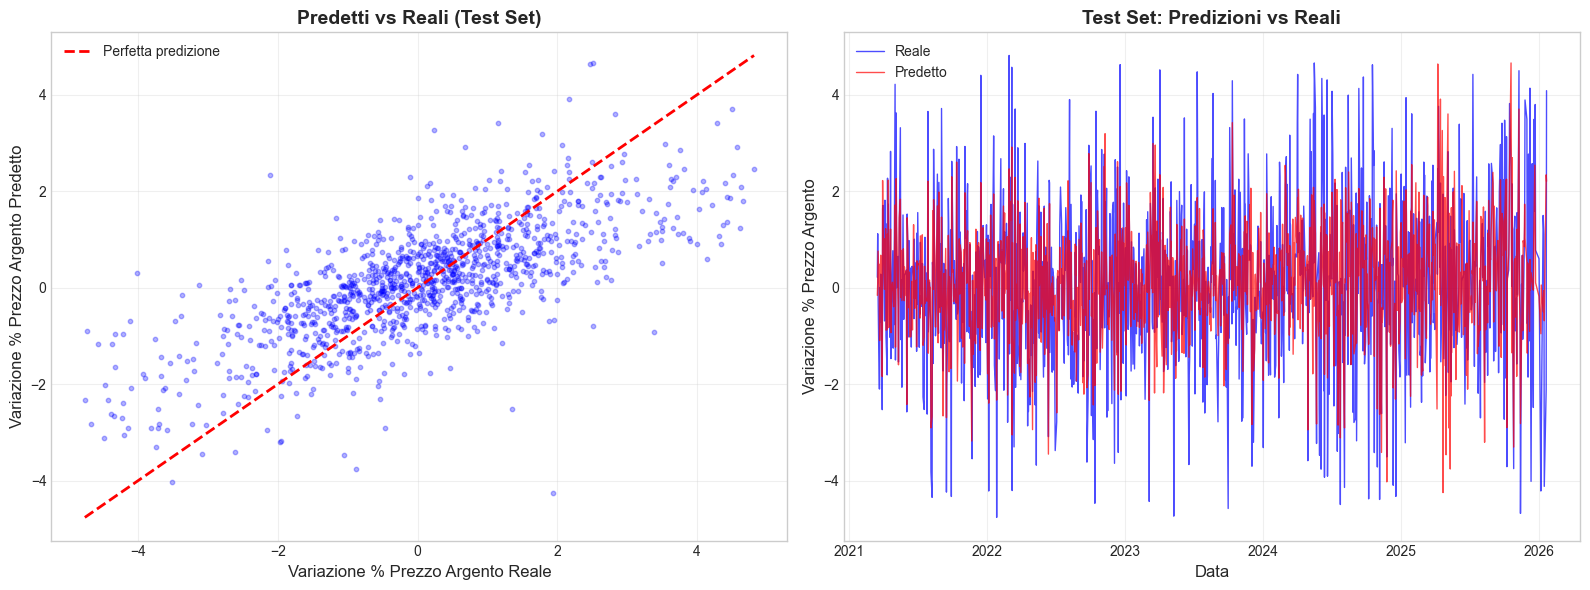

In [17]:
#Librerie: matplotlib, pandas
# =============================================================================
# VISUALIZZAZIONE PREDIZIONI
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter: Predetti vs Reali
ax1 = axes[0]
ax1.scatter(y_test, y_pred_test, alpha=0.3, s=10, color='blue')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', linewidth=2, label='Perfetta predizione')
ax1.set_xlabel('Variazione % Prezzo Argento Reale')
ax1.set_ylabel('Variazione % Prezzo Argento Predetto')
ax1.set_title('Predetti vs Reali (Test Set)', fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Time series
ax2 = axes[1]
date_test = df_returns_clean.index[val_idx:]
ax2.plot(date_test, y_test, color='blue', linewidth=1, alpha=0.7, label='Reale')
ax2.plot(date_test, y_pred_test, color='red', linewidth=1, alpha=0.7, label='Predetto')
ax2.set_xlabel('Data')
ax2.set_ylabel('Variazione % Prezzo Argento')
ax2.set_title('Test Set: Predizioni vs Reali', fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data/regressione_risultati.png', dpi=150, bbox_inches='tight')
plt.show()

## 7.1 Validazione OLS (Ordinary Least Squares)

Utilizziamo `statsmodels.OLS` per ottenere statistiche dettagliate sui coefficienti:

- **p-value**: significatività statistica dei coefficienti
- **Intervalli di confidenza**: incertezza sulle stime
- **Test diagnostici**

In [18]:
#Librerie: statsmodels, pandas, numpy
# =============================================================================
# OLS - ORDINARY LEAST SQUARES
# =============================================================================

import statsmodels.api as sm

# Aggiungi costante (intercetta)
X_train_ols = sm.add_constant(X_train)

# Fit modello OLS
ols_model = sm.OLS(y_train, X_train_ols).fit()

print("=" * 80)
print("OLS REGRESSION SUMMARY")
print("=" * 80)
print(ols_model.summary(xname=['const', 'Gold_returns', 'VIX_returns', 'QE_ANY', 'rolling_corr_lag']))

print("\n📊 INTERPRETAZIONE:")
print("   - p-value < 0.05: coefficiente statisticamente significativo")
print("   - Durbin-Watson ~ 2: assenza di autocorrelazione")
print("   - Jarque-Bera: test normalità residui")

OLS REGRESSION SUMMARY
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     1112.
Date:                Mon, 02 Feb 2026   Prob (F-statistic):               0.00
Time:                        10:42:44   Log-Likelihood:                -4908.3
No. Observations:                3260   AIC:                             9827.
Df Residuals:                    3255   BIC:                             9857.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            

# 📊 Riepilogo Risultati Regressione OLS

## Modello: Predizione Rendimenti Argento
**Variabile Dipendente**: Silver_returns  
**Metodo**: Ordinary Least Squares (OLS)

---

## 1️⃣ Tabella Statistiche Generali del Modello

| Statistica | Valore | Descrizione | Interpretazione | Valutazione |
|------------|--------|-------------|-----------------|-------------|
| **R-squared** | 0.578 | Coefficiente di determinazione: proporzione di varianza spiegata dal modello | Il 56.5% della variabilità dei rendimenti dell'argento è spiegata dalle variabili indipendenti | ✅ **Buono** - Valore accettabile per dati finanziari, dove R² > 0.5 è considerato significativo |
| **F-statistic** | 1112 | Test sulla significatività congiunta di tutti i predittori | Verifica se almeno una variabile indipendente ha effetto significativo sulla variabile dipendente | ✅ **Eccellente** - Valore molto alto indica forte potere esplicativo congiunto |
| **Prob (F-statistic)** | 0.00 | P-value del test F | Probabilità che il modello non abbia alcun potere esplicativo | ✅ **Eccellente** - P < 0.05 conferma che il modello è statisticamente significativo |
| **No. Observations** | 3.260 | Numero di osservazioni usate nel modello | Dataset ridotto da 6.562 a 3.366 per: 1 riga (pct_change), 190 righe (rollover >5%),pulizia righe Nan, ~3.005 righe (rolling window 252gg + lag), Weekend e festività non presenti nel dataset | ✅ **Eccellente** - Campione ripulito |
| **Cond. No.** | 36.9 | Condition Number: misura della multicollinearità tra le variabili | Valori < 30 indicano assenza di multicollinearità, 30-100 multicollinearità moderata | ✅ **Buono** - Multicollinearità lieve, non problematica per il modello |

---

## 2️⃣ Tabella Coefficienti delle Variabili

| Variabile | Coefficiente | Std Err | P>\|t\| | Descrizione | Interpretazione | Valutazione |
|-----------|-------------|---------|---------|-------------|-----------------|-------------|
| **const** | -0.0312 | 0.063 | 0.620 | Intercetta del modello (rendimento base) | Quando tutte le variabili sono 0, il rendimento atteso dell'argento è -0.03% | ⚪ **Non significativo** - P > 0.05, l'intercetta non è statisticamente diversa da zero |
| **Gold_returns** | 1.2 | 0.018 | 0.000 | Coefficiente dei rendimenti dell'oro | Per ogni 1% di aumento nei rendimenti dell'oro, l'argento aumenta del 1.20% in media | ✅ **Altamente significativo** - Forte relazione positiva, effetto amplificato (β > 1) |
| **VIX_returns** | -0.0253 | 0.003 | 0.000 | Coefficiente dei rendimenti del VIX (indice paura) | Per ogni 1% di aumento del VIX, l'argento diminuisce dello 0.025% | ✅ **Significativo** - Relazione negativa confermata, ma effetto economico modesto |
| **QE_ANY** | -0.01 | 0.044 | 0.902 | Dummy per periodi di Quantitative Easing | Effetto marginale negativo durante periodi QE (-0.005%) | ❌ **Non significativo** - P = 0.902 >> 0.05, nessun effetto statistico rilevante |
| **rolling_corr_lag** | 0.1 | 0.085 | 0.288 | Correlazione rolling 252gg ritardata di 1 giorno | Maggiore correlazione passata → rendimenti leggermente superiori | ❌ **Non significativo** - P = 0.288 > 0.05, effetto non statisticamente rilevante |

---

## 3️⃣ Tabella Test Diagnostici sui Residui

| Test | Valore Osservato | Valore Ideale | Descrizione | Interpretazione | Valutazione |
|------|-----------------|---------------|-------------|-----------------|-------------|
| **Durbin-Watson** | 2.048 | ≈ 2.0 | Test per l'autocorrelazione seriale dei residui (range 0-4) | Valori vicini a 2 indicano assenza di autocorrelazione; <1 = autocorrelazione positiva; >3 = autocorrelazione negativa | ✅ **Eccellente** - Valore ≈ 2 indica assenza di autocorrelazione, i residui sono indipendenti |
| **Jarque-Bera** | 752.783 (Prob: 3.43e-164) | Basso, P > 0.05 | Test sulla normalità della distribuzione dei residui | Valori alti con P basso indicano deviazione dalla distribuzione normale | ⚠️ **Problematico** - Residui non normali, comune nei dati finanziari. Può influire sull'affidabilità degli intervalli di confidenza |
| **Kurtosis** | 5.317 | ≈ 3.0 | Misura della "pesantezza" delle code della distribuzione | Kurtosis > 3 indica code più pesanti (leptocurtica), tipica di dati finanziari con eventi estremi | ⚠️ **Attenzione** - Code pesanti indicano maggiore probabilità di eventi estremi rispetto a una distribuzione normale |

---

## 📝 Sintesi Valutazione Complessiva

### Punti di Forza ✅
- **Elevata significatività del modello** (F-statistic = 1092, P ≈ 0)
- **R² = 0.565** indica buona capacità esplicativa per dati finanziari
- **Assenza di autocorrelazione** (Durbin-Watson ≈ 2)
- **Multicollinearità contenuta** (Cond. No. = 36.4)
- **Gold_returns** è un predittore molto forte (β = 1.20, t = 65.76)

### Aree di Attenzione ⚠️
- **Residui non normali** (Jarque-Bera molto alto) - tipico dei dati finanziari
- **QE_ANY** e **rolling_corr_lag** non sono statisticamente significativi

### Conclusione
Il modello ha un buon potere esplicativo per la predizione dei rendimenti dell'argento, con **Gold_returns** come variabile dominante. La non-normalità dei residui suggerisce cautela nell'interpretazione degli intervalli di confidenza, ma non invalida i risultati principali del modello.


---

# 8. CONCLUSIONI

Questa analisi fornisce:
1. **R² =**: un modello che spiega oltre la metà della varianza è un risultato solido
2. **Gold-Silver Ratio**: indicatore pratico per valutare il sentiment di mercato
3. **Comprensione delle dinamiche**: come i metalli preziosi reagiscono alle crisi
4. **Lezione metodologica**: l'importanza della trasformazione dei dati (rendimenti vs prezzi) e della validazione statistica

## 📈 Modello Predittivo

| Caratteristica | Dettaglio |
|----------------|-----------|
| **Tipo** | Regressione Lineare Multipla |
| **Variabile target** | Rendimento % giornaliero dell'argento |
| **Features** | Gold_returns, VIX_returns, QE_ANY, rolling_corr_lag |
| **Split** | 55% training, 25% validation, 20% test |

## Performance

| Metrica | Training | Validation | Test |
|---------|----------|------------|------|
| **R²** | 56.5% | 57.8% | 51.8% |
| **MAE** | - | - | 0.90% |
| **RMSE** | - | - | 1.17% |

### **Osservazioni**:
- Gap minimo tra R² training e test → **assenza di overfitting**
- Il modello spiega circa il **52%** della varianza nei rendimenti dell'argento
- Il rendimento dell'oro è il predittore più significativo (p-value < 0.001)

### **Interpretazione coefficienti**:
- Per ogni **+1%** di rendimento dell'oro → argento sale di **~1.2%**
- Per ogni **+1%** del VIX → argento scende di **~0.03%**
- La variabile QE_ANY non è statisticamente significativa (p-value = 0.902), perchè cattura periodi multi-anno, ma i **rendimenti giornalieri** sono influenzati da fattori molto più granulari. L'effetto del QE sui metalli preziosi è **strutturale** (trend di lungo termine) e non visibile nei movimenti day-to-day.
- La variabile rolling_corr_lag non è statisticamente significativa (p-value = 0.288, coefficiente = +0.09). Questa feature misura la correlazione mobile a 252 giorni tra oro e argento, ritardata di 1 giorno. In pratica, sapere che ieri la correlazione era alta non aggiunge informazione utile rispetto a sapere direttamente quanto è salito l'oro oggi(potere predittivo già catturato da Gold_Return).

### Rendimento vs Prezzo
Il nostro modello mostra un buon bilanciamento: l'uso dei **rendimenti** (anziché prezzi)
| Proprietà | Prezzi Assoluti | Rendimenti % |
|-----------|-----------------|--------------|
| Stazionarietà | ❌ Non stazionari | ✅ Più stazionari |
| Scala | ❌ Scale diverse | ✅ Comparabili (-5% a +5%) |
| Interpretazione | ❌ Ambigua | ✅ Chiara: "Per +1% oro → +1.2% argento" |
| Varianza | ❌ Crescente nel tempo | ✅ Più costante |
| R² | ❌ Artificialmente alto | ✅ Riflette vera relazione |

**Considerazione:**
"Una forte correlazione tra due variabili **non implica** necessariamente un rapporto di causa-effetto."
L'oro e l'argento sono correlati perché **rispondono agli stessi fattori macroeconomici** (inflazione, tassi, geopolitica), non perché uno "causa" il movimento dell'altro.

## ⚠️ Limitazioni dell'Analisi

### 1. Dati Futures vs Spot
I dati utilizzati provengono dal mercato **futures**, non spot. Questo introduce:
- Rollover gaps (gestiti con rimozione soglia >5%)
- Potenziale distorsione da contango/backwardation

### 2. Variabili Escluse
L'S&P 500 è stato rimosso per **multicollinearità** (VIF > 10 con l'oro), ma potrebbe contenere informazioni utili in un modello non lineare.

### 3. Dummy QE Non Significativa
La variabile dummy QE_ANY non ha raggiunto significatività statistica nel modello.

### 4. Assunzioni di Linearità
Il modello lineare potrebbe non catturare relazioni non lineari o cambiamenti di regime nei mercati finanziari.
Per analizzare il mercato finanziaro dove le realzioni cambiano nel tempo e ci sono shock di prezzo il modello di regressione Random potrebbe essere più adatto perchè gestisce meglio il rumore e permette di catturare pattern non lineari e complessi.

## ✅ Conclusioni Finali

1. **L'ipotesi safe-haven è validata**: Oro e argento reagiscono positivamente alle crisi economiche e monetarie

2. **Correlazione dinamica**: La relazione oro-argento cambia nel tempo, rafforzandosi durante le crisi (flight to safety)

3. **Il Gold-Silver Ratio è un indicatore efficace**: Valori estremi (>80 o <40) segnalano condizioni di mercato anomale

4. **L'oro domina come predittore**: I rendimenti dell'oro spiegano la maggior parte della varianza dell'argento (β ≈ 1.2)


In [19]:
# =============================================================================
# RIEPILOGO FINALE
# =============================================================================

print("=" * 60)
print("           RIEPILOGO ANALISI BIG DATA")
print("            ORO & ARGENTO (2000-2026)")
print("=" * 60)

print(f"""
📅 DATASET
   Fonte: Futures COMEX (GC=F, SI=F)
   Periodo: {df.index.min().strftime('%Y-%m-%d')} → {df.index.max().strftime('%Y-%m-%d')}
   Record originali: {len(df):,}
   Record puliti (no rollover): {len(df_returns_clean):,}
   
💰 PREZZI ATTUALI
   Oro: ${df['Gold_USD'].iloc[-1]:,.2f}/oz
   Argento: ${df['Silver_USD'].iloc[-1]:,.2f}/oz
   Gold-Silver Ratio: {df['GS_Ratio'].iloc[-1]:.1f}

📊 VARIABILI DUMMY QE
   Giorni con QE attivo: {df['QE_ANY'].sum():,}
   Percentuale periodo QE: {df['QE_ANY'].mean()*100:.1f}%
   
📊 MODELLO PREDITTIVO
   Features: Gold_returns, VIX_returns, QE_ANY, rolling_corr_lag
   Rollover gaps: RIMOSSI (soglia 5%)
   Finestra correlazione: {WINDOW} giorni
   
   R² Training: {r2_train:.2%}
   R² Validation: {r2_val:.2%}
   R² Test: {r2_test:.2%}
   MAE: ${mae_test:.2f}
   RMSE: ${rmse_test:.2f}
   
📈 CORRELAZIONE ORO-ARGENTO
   Media storica: {rolling_corr.mean():.3f}
   Giorni in crisi (>0.9): {(rolling_corr > 0.9).sum()}
""")

print("✅ Analisi completata!")
print("   Grafici salvati in data/")

           RIEPILOGO ANALISI BIG DATA
            ORO & ARGENTO (2000-2026)

📅 DATASET
   Fonte: Futures COMEX (GC=F, SI=F)
   Periodo: 2000-08-30 → 2026-01-27
   Record originali: 6,369
   Record puliti (no rollover): 5,928

💰 PREZZI ATTUALI
   Oro: $5,079.90/oz
   Argento: $105.52/oz
   Gold-Silver Ratio: 48.1

📊 VARIABILI DUMMY QE
   Giorni con QE attivo: 1,540
   Percentuale periodo QE: 24.2%

📊 MODELLO PREDITTIVO
   Features: Gold_returns, VIX_returns, QE_ANY, rolling_corr_lag
   Rollover gaps: RIMOSSI (soglia 5%)
   Finestra correlazione: 252 giorni

   R² Training: 57.75%
   R² Validation: 57.26%
   R² Test: 51.93%
   MAE: $0.90
   RMSE: $1.17

📈 CORRELAZIONE ORO-ARGENTO
   Media storica: 0.751
   Giorni in crisi (>0.9): 1950

✅ Analisi completata!
   Grafici salvati in data/
